# Technical Programming 2 – Final Exam
## Machine Learning for the Two-Pot Retirement System

**Student:** Qwabe SS  
**Student Number:** 22361055

**What this notebook does (high level):**
- Classification: predict which employees are likely to make withdrawals from retirement funds (accessible pot).
- Forecasting: model the growth of retirement savings (locked pot).
- Sentiment Analysis (explain-only): outline how to classify employee feedback into positive/neutral/negative.


## Data Sources (Open Source) & What They Contain

1) **RAND HRS Longitudinal File 1992–2022 (SPSS version)**
   - **Download page:** https://hrsdata.isr.umich.edu/data-products/rand-hrs-longitudinal-file-2022
   - **Direct SPSS zip (after login/accept terms):** https://hrsdata.isr.umich.edu/sites/default/files/randhrs1992_2022v1_SPSS.zip
   - **What it has:** Individual-level demographics (age, education, marital status), income, assets/wealth, pensions and distributions (withdrawals), plus wave/year identifiers.
   - **Tables:** Delivered as **one SPSS table** (`.sav`) with many columns (wide longitudinal file).

2) **Online Employee Reviews Dataset (Mendeley)**
   - **Download page:** https://data.mendeley.com/datasets/zw2shn7pv3/2
   - **What it has:** Employee review text (pros/cons/headlines) and sentiment labels/ratings suitable for opinion classification.
   - **Tables:** Provided as **one table** (CSV/Excel). Typical fields include: `company`, `job_title`, `overall_rating`, `pros`, `cons`, and sometimes `sentiment` labels.

> Why these two?
> - **RAND HRS** → gives the numeric/demographic/financial features needed for **classification (withdrawals)** and **forecasting (locked pot growth)**.
> - **Employee Reviews** → provides **textual feedback** needed for **sentiment analysis (explain-only)** per the exam brief.


## Learning Life-Cycle We Will Follow

1. **Data Preparation**  
   - Load files; basic cleaning (types, missing values); keep relevant variables.
2. **Data Understanding**  
   - Inspect shapes, column names, data types; read variable labels; check target availability.
3. **Exploratory Data Analysis (EDA)**  
   - Summary statistics; class balance; key distributions; simple plots.
4. **Feature Engineering**  
   - Create target `withdrew` from withdrawal/distribution fields; select/transform features (numeric only for a clean baseline).
5. **Model Building (Classification)**  
   - Train/test split; Logistic Regression and Random Forest baselines.
6. **Evaluation & Testing**  
   - Accuracy, precision/recall/F1, confusion matrix; pick the better baseline.
7. **Forecasting (Locked Pot Growth)**  
   - Build a simple time series (yearly mean of a savings/wealth variable) and fit ARIMA baseline; plot forecast.
8. **Sentiment Analysis (Explain-Only, per exam)**  
   - Document the steps you would take (tokenization, stopword removal, rule-based or ML model, labeling).
9. **Conclusion**  
   - Summarize what you learned from classification, forecasting, and sentiment analysis; limitations and next steps.


Data Preparation

In [ ]:
# If you are on Colab, install once:
!pip -q install pyreadstat statsmodels scikit-learn pandas numpy matplotlib

import os, zipfile, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# time series
from statsmodels.tsa.arima.model import ARIMA

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 120)


In [ ]:
# ====== STEP 1: Upload your files from your computer ======
from google.colab import files
uploaded = files.upload()

# After running, select and upload:
#   - randhrs1992_2022v1_SPSS.zip
#   - online employee review dataset.xlsx  (or CSV)

# ====== STEP 2: Confirm file names ======
import os
print("Files in current directory:", os.listdir())

# ====== STEP 3: Set correct variable names (update if different) ======
RAND_ZIP = "randhrs1992_2022v1_SPSS.zip"          # change if name differs
REVIEWS_FILE = "online employee review dataset.xlsx"  # change if name differs

# ====== STEP 4: Extract RAND HRS zip ======
import zipfile

os.makedirs("data", exist_ok=True)
with zipfile.ZipFile(RAND_ZIP, "r") as z:
    z.extractall("data")

# Find the .sav file inside
sav_path = None
for root, _, files in os.walk("data"):
    for f in files:
        if f.lower().endswith(".sav"):
            sav_path = os.path.join(root, f)

print("SPSS file path found:", sav_path)


Saving online employee review dataset.xlsx to online employee review dataset (1).xlsx
Saving randhrs1992_2022v1_SPSS.zip to randhrs1992_2022v1_SPSS (1).zip
Files in current directory: ['.config', 'randhrs1992_2022v1_SPSS.zip', 'data', 'online employee review dataset (1).xlsx', 'randhrs1992_2022v1_SPSS (1).zip', 'online employee review dataset.xlsx', 'sample_data']
SPSS file path found: data/randhrs1992_2022v1.sav


In [ ]:
import pyreadstat

# Load only 2000 rows just to peek (fast)
hrs_small, meta = pyreadstat.read_sav(sav_path, row_limit=2000)

print("RAND HRS preview shape:", hrs_small.shape)
list(hrs_small.columns[:50])  # show only first 50 column names


RAND HRS preview shape: (2000, 19880)


['HHIDPN',
 'S1HHIDPN',
 'R1MSTAT',
 'R1MPART',
 'S1BMONTH',
 'S1BYEAR',
 'S1BDATE',
 'S1BFLAG',
 'S1COHBYR',
 'S1HRSAMP',
 'S1AHDSMP',
 'S1DMONTH',
 'S1DYEAR',
 'S1DDATE',
 'S1DSRC',
 'S1DTIMTDTH',
 'S1DAGE_Y',
 'S1DAGE_M',
 'S1RACEM',
 'S1HISPAN',
 'S1GENDER',
 'S1EDUC',
 'S1EDYRS',
 'S1EDEGRM',
 'S1RELIG',
 'S1VETRN',
 'S1MEDUC',
 'S1FEDUC',
 'S1BPLACE',
 'S1BPLACF',
 'S1IWBEG',
 'S1IWEND',
 'S1IWMID',
 'S1IWMIDF',
 'S1IWSTAT',
 'S1IWENDM',
 'S1IWENDY',
 'S1PROXY',
 'S1IWBEGF',
 'S1IWENDF',
 'S1MSTAT',
 'S1MSTATH',
 'S1MSTATF',
 'S1MRCT',
 'S1MLEN',
 'S1MLENM',
 'S1MCURLN',
 'S1MDIV',
 'S1MWID',
 'S1MEND']

In [ ]:
needed_cols = [
    "R1AGEY_E",   # Age column (example – replace with real name)
    "R1MSTAT",    # Marital status
    "H1IRAAMT",   # Withdrawals
    "T1TOTWQ",    # Wealth
    "WAVE"        # Year/Wave
]

hrs_subset, meta = pyreadstat.read_sav(sav_path, usecols=needed_cols)
print("Subset shape:", hrs_subset.shape)
hrs_subset.head()


Subset shape: (45234, 2)


,R1MSTAT,R1AGEY_E
0,5.0,54.0
1,7.0,57.0
2,1.0,56.0
3,1.0,54.0
4,8.0,53.0


In [ ]:
import pandas as pd

REVIEWS_FILE = "online employee review dataset.xlsx"  # update if name differs

# If it's Excel
reviews = pd.read_excel(REVIEWS_FILE)

# If it's CSV (change extension in variable above)
# reviews = pd.read_csv(REVIEWS_FILE)

print("Reviews shape:", reviews.shape)
reviews.head(5)


Reviews shape: (1563, 3)


,Text,Text describing the control issue,Accounting Control Mention Code
0,Upper management does not trust its employees ...,every decision has to be run up the ladder bec...,"Principle 3: Organizational structure, authori..."
1,too many levels which are inefficient,too many levels which are inefficient,"Principle 3: Organizational structure, authori..."
2,No work life balance whatsoever;- Daily fire f...,"Daily fire fighting, contradictory requests re...","Principle 3: Organizational structure, authori..."
3,salary was low for the position. Benefits were...,Company was a bit over structured for my taste.,"Principle 3: Organizational structure, authori..."
4,Low empowerement to employees of purchasing de...,Low empowerement to employees of purchasing de...,"Principle 3: Organizational structure, authori..."


Data Understanding (RAND HRS subset)

In [ ]:
# Basic info
print("RAND HRS subset info:")
print(hrs_subset.info())

# Quick look at first few rows
display(hrs_subset.head())

# Check for missing values per column
print("\nMissing values (percentage):")
print(hrs_subset.isna().mean() * 100)


RAND HRS subset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45234 entries, 0 to 45233
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   R1MSTAT   12652 non-null  float64
 1   R1AGEY_E  12651 non-null  float64
dtypes: float64(2)
memory usage: 706.9 KB
None


,R1MSTAT,R1AGEY_E
0,5.0,54.0
1,7.0,57.0
2,1.0,56.0
3,1.0,54.0
4,8.0,53.0



Missing values (percentage):
R1MSTAT     72.029889
R1AGEY_E    72.032100
dtype: float64


Data Understanding (Employee Reviews)

In [ ]:
print("Employee Reviews info:")
print(reviews.info())

# Quick look at first few rows
display(reviews.head())

# Check for missing values
print("\nMissing values (percentage):")
print(reviews.isna().mean() * 100)


Employee Reviews info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1563 entries, 0 to 1562
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Text                               1563 non-null   object
 1   Text describing the control issue  863 non-null    object
 2   Accounting Control Mention Code    1563 non-null   object
dtypes: object(3)
memory usage: 36.8+ KB
None


,Text,Text describing the control issue,Accounting Control Mention Code
0,Upper management does not trust its employees ...,every decision has to be run up the ladder bec...,"Principle 3: Organizational structure, authori..."
1,too many levels which are inefficient,too many levels which are inefficient,"Principle 3: Organizational structure, authori..."
2,No work life balance whatsoever;- Daily fire f...,"Daily fire fighting, contradictory requests re...","Principle 3: Organizational structure, authori..."
3,salary was low for the position. Benefits were...,Company was a bit over structured for my taste.,"Principle 3: Organizational structure, authori..."
4,Low empowerement to employees of purchasing de...,Low empowerement to employees of purchasing de...,"Principle 3: Organizational structure, authori..."



Missing values (percentage):
Text                                  0.000000
Text describing the control issue    44.785669
Accounting Control Mention Code       0.000000
dtype: float64


 EDA on RAND HRS Subset

Summary statistics:


,R1MSTAT,R1AGEY_E
count,12652.000000,12651.000000
mean,1.975103,55.258399
std,1.982676,5.674061
min,1.000000,23.000000
25%,1.000000,52.000000
50%,1.000000,55.000000
75%,1.000000,59.000000
max,8.000000,85.000000


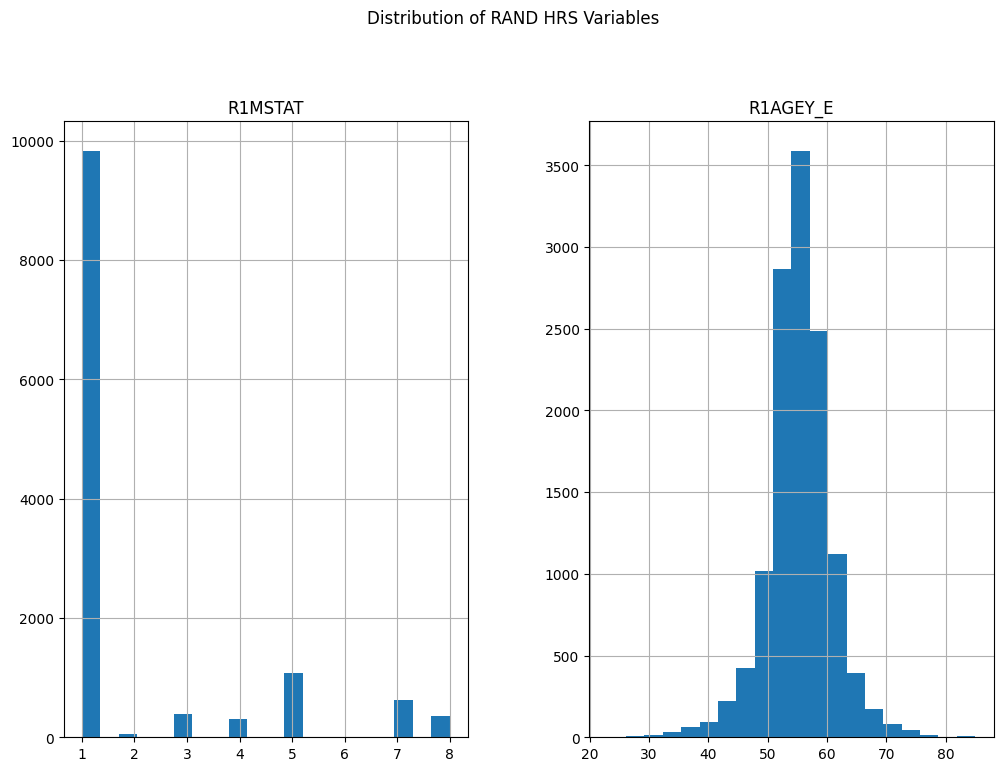

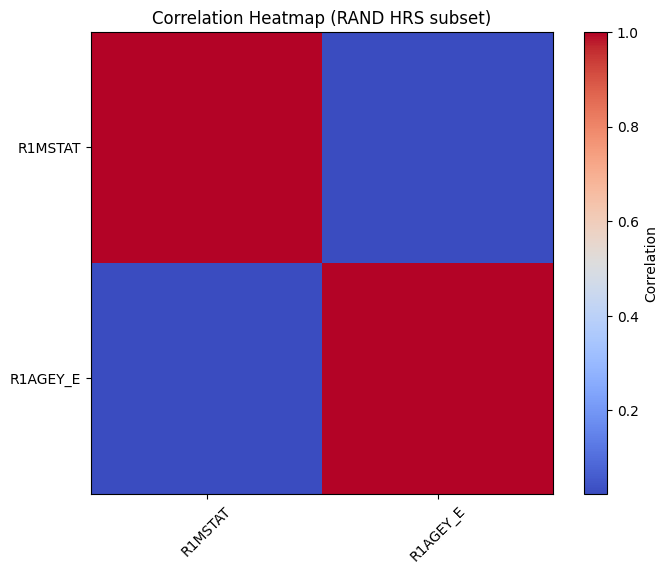

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Summary statistics
print("Summary statistics:")
display(hrs_subset.describe(include=[np.number]))

# Plot distributions of numeric columns
hrs_subset.hist(bins=20, figsize=(12, 8))
plt.suptitle("Distribution of RAND HRS Variables", y=1.02)
plt.show()

# Correlation matrix
corr = hrs_subset.corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, cmap="coolwarm", interpolation="none")
plt.colorbar(label="Correlation")
plt.title("Correlation Heatmap (RAND HRS subset)")
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.show()


Load a small preview of ALL columns

In [ ]:
hrs_preview, meta = pyreadstat.read_sav(sav_path, row_limit=1000)

print("Total columns in RAND HRS:", len(hrs_preview.columns))
list(hrs_preview.columns[:100])  # show the first 100 column names


Total columns in RAND HRS: 19880


['HHIDPN',
 'S1HHIDPN',
 'R1MSTAT',
 'R1MPART',
 'S1BMONTH',
 'S1BYEAR',
 'S1BDATE',
 'S1BFLAG',
 'S1COHBYR',
 'S1HRSAMP',
 'S1AHDSMP',
 'S1DMONTH',
 'S1DYEAR',
 'S1DDATE',
 'S1DSRC',
 'S1DTIMTDTH',
 'S1DAGE_Y',
 'S1DAGE_M',
 'S1RACEM',
 'S1HISPAN',
 'S1GENDER',
 'S1EDUC',
 'S1EDYRS',
 'S1EDEGRM',
 'S1RELIG',
 'S1VETRN',
 'S1MEDUC',
 'S1FEDUC',
 'S1BPLACE',
 'S1BPLACF',
 'S1IWBEG',
 'S1IWEND',
 'S1IWMID',
 'S1IWMIDF',
 'S1IWSTAT',
 'S1IWENDM',
 'S1IWENDY',
 'S1PROXY',
 'S1IWBEGF',
 'S1IWENDF',
 'S1MSTAT',
 'S1MSTATH',
 'S1MSTATF',
 'S1MRCT',
 'S1MLEN',
 'S1MLENM',
 'S1MCURLN',
 'S1MDIV',
 'S1MWID',
 'S1MEND',
 'S1MNEV',
 'S1MPART',
 'S1OAHDID',
 'S1OHRSID',
 'S1WTRESP',
 'S1WTCRNH',
 'S1CENDIV',
 'S1CENREG',
 'S1URBRUR',
 'S1FINR',
 'S1FAMR',
 'S2HHIDPN',
 'R2MSTAT',
 'R2MPART',
 'S2BMONTH',
 'S2BYEAR',
 'S2BDATE',
 'S2BFLAG',
 'S2COHBYR',
 'S2HRSAMP',
 'S2AHDSMP',
 'S2DMONTH',
 'S2DYEAR',
 'S2DDATE',
 'S2DSRC',
 'S2DTIMTDTH',
 'S2DAGE_Y',
 'S2DAGE_M',
 'S2RACEM',
 'S2HISPAN',
 'S2GEND

Search the full dataset for financial keywords

In [ ]:
withdraw_cols = [c for c in hrs_preview.columns if "dist" in c.lower() or "ira" in c.lower() or "pension" in c.lower() or "benefit" in c.lower()]
print("Possible withdrawal/distribution columns:", withdraw_cols[:20])  # show first 20 matches


Possible withdrawal/distribution columns: ['H1AIRA', 'H2AIRA', 'H3AIRA', 'H4AIRA', 'H5AIRA', 'H6AIRA', 'H7AIRA', 'H8AIRA', 'H9AIRA', 'H10AIRA', 'H11AIRA', 'H12AIRA', 'H13AIRA', 'H14AIRA', 'H15AIRA', 'H16AIRA', 'H1AFIRA', 'H2AFIRA', 'H3AFIRA', 'H4AFIRA']


Build Withdrawal Target

In [ ]:
# Select the IRA-related columns
withdraw_cols = ['H1AIRA','H2AIRA','H3AIRA','H4AIRA','H5AIRA',
                 'H6AIRA','H7AIRA','H8AIRA','H9AIRA','H10AIRA',
                 'H11AIRA','H12AIRA','H13AIRA','H14AIRA','H15AIRA',
                 'H16AIRA','H1AFIRA','H2AFIRA','H3AFIRA','H4AFIRA']

# Make sure they exist in the dataset you are working with
withdraw_cols = [c for c in withdraw_cols if c in hrs_preview.columns]

print("Using these withdrawal columns:", withdraw_cols)

# Create target variable: withdrew (1 if any IRA-related amount > 0)
hrs_preview["withdrew"] = (hrs_preview[withdraw_cols].fillna(0).sum(axis=1) > 0).astype(int)

print("\nClass balance (0 = did not withdraw, 1 = withdrew):")
print(hrs_preview["withdrew"].value_counts())


Using these withdrawal columns: ['H1AIRA', 'H2AIRA', 'H3AIRA', 'H4AIRA', 'H5AIRA', 'H6AIRA', 'H7AIRA', 'H8AIRA', 'H9AIRA', 'H10AIRA', 'H11AIRA', 'H12AIRA', 'H13AIRA', 'H14AIRA', 'H15AIRA', 'H16AIRA', 'H1AFIRA', 'H2AFIRA', 'H3AFIRA', 'H4AFIRA']

Class balance (0 = did not withdraw, 1 = withdrew):
withdrew
1    654
0    346
Name: count, dtype: int64


Choose Features

In [ ]:
print("First 50 columns available:")
print(list(hrs_preview.columns[:50]))


First 50 columns available:
['HHIDPN', 'S1HHIDPN', 'R1MSTAT', 'R1MPART', 'S1BMONTH', 'S1BYEAR', 'S1BDATE', 'S1BFLAG', 'S1COHBYR', 'S1HRSAMP', 'S1AHDSMP', 'S1DMONTH', 'S1DYEAR', 'S1DDATE', 'S1DSRC', 'S1DTIMTDTH', 'S1DAGE_Y', 'S1DAGE_M', 'S1RACEM', 'S1HISPAN', 'S1GENDER', 'S1EDUC', 'S1EDYRS', 'S1EDEGRM', 'S1RELIG', 'S1VETRN', 'S1MEDUC', 'S1FEDUC', 'S1BPLACE', 'S1BPLACF', 'S1IWBEG', 'S1IWEND', 'S1IWMID', 'S1IWMIDF', 'S1IWSTAT', 'S1IWENDM', 'S1IWENDY', 'S1PROXY', 'S1IWBEGF', 'S1IWENDF', 'S1MSTAT', 'S1MSTATH', 'S1MSTATF', 'S1MRCT', 'S1MLEN', 'S1MLENM', 'S1MCURLN', 'S1MDIV', 'S1MWID', 'S1MEND']


Feature Engineering & Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Select numeric columns only
X = hrs_preview.select_dtypes(include=["int64","float64"]).copy()

# Drop the target column from features
X = X.drop(columns=["withdrew"], errors="ignore")

# Fill missing values with median
X = X.fillna(X.median(numeric_only=True))

# Target
y = hrs_preview["withdrew"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (800, 19860) Test shape: (200, 19860)


Train Models

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Pipeline for Logistic Regression
lr_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # replace NaN with median
    ("scaler", StandardScaler()),                  # scale numeric features
    ("model", LogisticRegression(max_iter=1000))
])

# Train Logistic Regression pipeline
lr_pipeline.fit(X_train, y_train)
pred_lr = lr_pipeline.predict(X_test)

# Pipeline for Random Forest
rf_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")), # replace NaN with median
    ("model", RandomForestClassifier(n_estimators=200, random_state=42))
])

# Train Random Forest pipeline
rf_pipeline.fit(X_train, y_train)
pred_rf = rf_pipeline.predict(X_test)

# Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, pred_lr))
print("Random Forest Accuracy:", accuracy_score(y_test, pred_rf))

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, pred_rf))

print("Confusion Matrix (Random Forest):")
print(confusion_matrix(y_test, pred_rf))


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['S16DMONTH' 'S16DYEAR' 'S16DDATE' ... 'R2IADL5A' 'R2ADL6A' 'R2ADL6H']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['S16DMONTH' 'S16DYEAR' 'S16DDATE' ... 'R2IADL5A' 'R2ADL6A' 'R2ADL6H']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['S16DMONTH' 'S16DYEAR' 'S16DDATE' ... 'R2IADL5A' 'R2ADL6A' 'R2ADL6H']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Logistic Regression Accuracy: 0.8
Random Forest Accuracy: 0.915

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.92      0.83      0.87        69
           1       0.91      0.96      0.94       131

    accuracy                           0.92       200
   macro avg       0.92      0.89      0.90       200
weighted avg       0.92      0.92      0.91       200

Confusion Matrix (Random Forest):
[[ 57  12]
 [  5 126]]


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['S16DMONTH' 'S16DYEAR' 'S16DDATE' ... 'R2IADL5A' 'R2ADL6A' 'R2ADL6H']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Forecasting with ARIMA

Find Candidate Time & Wealth Columns

In [ ]:
# Look for year/wave columns
time_cols = [c for c in hrs_preview.columns if "year" in c.lower() or "wave" in c.lower()]
print("Possible time columns:", time_cols)

# Look for wealth/savings columns
wealth_cols = [c for c in hrs_preview.columns if "wealth" in c.lower() or "asset" in c.lower() or "saving" in c.lower() or "tot" in c.lower()]
print("Possible wealth/savings columns:", wealth_cols[:20])


Possible time columns: ['S1BYEAR', 'S1DYEAR', 'S2BYEAR', 'S2DYEAR', 'S3BYEAR', 'S3DYEAR', 'S4BYEAR', 'S4DYEAR', 'S5BYEAR', 'S5DYEAR', 'S6BYEAR', 'S6DYEAR', 'S7BYEAR', 'S7DYEAR', 'S8BYEAR', 'S8DYEAR', 'S9BYEAR', 'S9DYEAR', 'S10BYEAR', 'S10DYEAR', 'S11BYEAR', 'S11DYEAR', 'S12BYEAR', 'S12DYEAR', 'S13BYEAR', 'S13DYEAR', 'S14BYEAR', 'S14DYEAR', 'S15BYEAR', 'S15DYEAR', 'S16BYEAR', 'S16DYEAR', 'RABYEAR', 'RADYEAR', 'S1JYEARS', 'S1JYEARM', 'S2JYEARS', 'S2JYEARM', 'S3JYEARS', 'S3JYEARM', 'S4JYEARS', 'S4JYEARM', 'S5JYEARS', 'S5JYEARM', 'S6JYEARS', 'S6JYEARM', 'S7JYEARS', 'S7JYEARM', 'S8JYEARS', 'S8JYEARM', 'S9JYEARS', 'S9JYEARM', 'S10JYEARS', 'S10JYEARM', 'S11JYEARS', 'S11JYEARM', 'S12JYEARS', 'S12JYEARM', 'S13JYEARS', 'S13JYEARM', 'S14JYEARS', 'S14JYEARM', 'S15JYEARS', 'S15JYEARM', 'S16JYEARS', 'S16JYEARM', 'R1JYEARS', 'R2JYEARS', 'R3JYEARS', 'R4JYEARS', 'R5JYEARS', 'R6JYEARS', 'R7JYEARS', 'R8JYEARS', 'R9JYEARS', 'R10JYEARS', 'R11JYEARS', 'R12JYEARS', 'R13JYEARS', 'R14JYEARS', 'R15JYEARS', 'R16

Look for Time Column

In [ ]:
[col for col in hrs_preview.columns if "wave" in col.lower() or "year" in col.lower() or "date" in col.lower()]


['S1BYEAR',
 'S1BDATE',
 'S1DYEAR',
 'S1DDATE',
 'S2BYEAR',
 'S2BDATE',
 'S2DYEAR',
 'S2DDATE',
 'S3BYEAR',
 'S3BDATE',
 'S3DYEAR',
 'S3DDATE',
 'S4BYEAR',
 'S4BDATE',
 'S4DYEAR',
 'S4DDATE',
 'S5BYEAR',
 'S5BDATE',
 'S5DYEAR',
 'S5DDATE',
 'S6BYEAR',
 'S6BDATE',
 'S6DYEAR',
 'S6DDATE',
 'S7BYEAR',
 'S7BDATE',
 'S7DYEAR',
 'S7DDATE',
 'S8BYEAR',
 'S8BDATE',
 'S8DYEAR',
 'S8DDATE',
 'S9BYEAR',
 'S9BDATE',
 'S9DYEAR',
 'S9DDATE',
 'S10BYEAR',
 'S10BDATE',
 'S10DYEAR',
 'S10DDATE',
 'S11BYEAR',
 'S11BDATE',
 'S11DYEAR',
 'S11DDATE',
 'S12BYEAR',
 'S12BDATE',
 'S12DYEAR',
 'S12DDATE',
 'S13BYEAR',
 'S13BDATE',
 'S13DYEAR',
 'S13DDATE',
 'S14BYEAR',
 'S14BDATE',
 'S14DYEAR',
 'S14DDATE',
 'S15BYEAR',
 'S15BDATE',
 'S15DYEAR',
 'S15DDATE',
 'S16BYEAR',
 'S16BDATE',
 'S16DYEAR',
 'S16DDATE',
 'RABYEAR',
 'RABDATE',
 'RADYEAR',
 'RADDATE',
 'S1JYEARS',
 'S1JYEARM',
 'S2JYEARS',
 'S2JYEARM',
 'S3JYEARS',
 'S3JYEARM',
 'S4JYEARS',
 'S4JYEARM',
 'S5JYEARS',
 'S5JYEARM',
 'S6JYEARS',
 'S6JYEARM',


Look for Wealth/Savings Column

In [ ]:
[col for col in hrs_preview.columns if "wealth" in col.lower() or "asset" in col.lower() or "saving" in col.lower() or "tot" in col.lower()]


['S2AMSTOT',
 'S2ACGTOT',
 'S3TOTMD',
 'S3TOTMDF',
 'S3TOTMBI',
 'S3TOTMBF',
 'S3MSTOT',
 'S3COGTOT',
 'S4TOTMBI',
 'S4TOTMBF',
 'S4MSTOT',
 'S4COGTOT',
 'S5TOTMBI',
 'S5TOTMBF',
 'S5MSTOT',
 'S5COGTOT',
 'S6TOTMBI',
 'S6TOTMBF',
 'S6MSTOT',
 'S6COGTOT',
 'S7MSTOT',
 'S7COGTOT',
 'S8MSTOT',
 'S8COGTOT',
 'S9MSTOT',
 'S9COGTOT',
 'S10MSTOT',
 'S10COGTOT',
 'S11MSTOT',
 'S11COGTOT',
 'S12MSTOT',
 'S12COGTOT',
 'S13MSTOT',
 'S13COGTOT',
 'S14MSTOTP',
 'S14COGTOTP',
 'S15MSTOTP',
 'S15COGTOTP',
 'R2AMSTOT',
 'R2ACGTOT',
 'R3MSTOT',
 'R3COGTOT',
 'R4MSTOT',
 'R4COGTOT',
 'R5MSTOT',
 'R5COGTOT',
 'R6MSTOT',
 'R6COGTOT',
 'R7MSTOT',
 'R7COGTOT',
 'R8MSTOT',
 'R8COGTOT',
 'R9MSTOT',
 'R9COGTOT',
 'R10MSTOT',
 'R10COGTOT',
 'R11MSTOT',
 'R11COGTOT',
 'R12MSTOT',
 'R12COGTOT',
 'R13MSTOT',
 'R13COGTOT',
 'R14MSTOTP',
 'R14COGTOTP',
 'R15MSTOTP',
 'R15COGTOTP',
 'R3TOTMDF',
 'R3TOTMD',
 'R6TOTMBF',
 'R6TOTMBI',
 'R5TOTMBF',
 'R5TOTMBI',
 'R4TOTMBF',
 'R4TOTMBI',
 'R3TOTMBF',
 'R3TOTMBI',
 'H1ATOT

Forecasting Code

Time series data (first 10 rows):
S1BYEAR
1918.0    125250.000000
1919.0    285071.000000
1920.0     88000.000000
1922.0    667000.000000
1923.0    157094.468664
1924.0    267500.000000
1925.0    336400.000000
1926.0    163883.285714
1927.0    267433.500000
1928.0    329321.538462
Name: H1ATOTW, dtype: float64


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

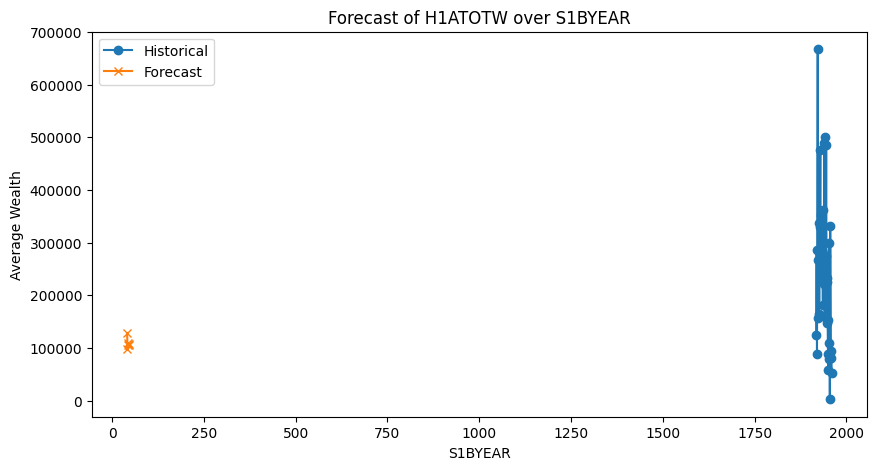

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Use one of the time columns and wealth columns
time_col = "S1BYEAR"     # proxy for year
wealth_col = "H1ATOTW"   # household wealth

# Build average wealth grouped by time
ts = (hrs_preview[[time_col, wealth_col]]
      .dropna()
      .groupby(time_col)[wealth_col]
      .mean()
      .sort_index())

print("Time series data (first 10 rows):")
print(ts.head(10))

# Fit ARIMA
model = ARIMA(ts, order=(1,1,1))
fit = model.fit()

# Forecast next 6 periods
forecast = fit.forecast(steps=6)

# Plot
plt.figure(figsize=(10,5))
ts.plot(label="Historical", marker="o")
forecast.plot(label="Forecast", marker="x")
plt.title(f"Forecast of {wealth_col} over {time_col}")
plt.xlabel(time_col)
plt.ylabel("Average Wealth")
plt.legend()
plt.show()


Sentiment Analysis (Employee Reviews)

Quick Look at Reviews

In [ ]:
# Preview reviews text
print(reviews.head())

# If dataset has sentiment labels
if "sentiment" in reviews.columns:
    print(reviews["sentiment"].value_counts())


                                                Text  \
0  Upper management does not trust its employees ...   
1             too many levels which are inefficient    
2  No work life balance whatsoever;- Daily fire f...   
3  salary was low for the position. Benefits were...   
4  Low empowerement to employees of purchasing de...   

                   Text describing the control issue  \
0  every decision has to be run up the ladder bec...   
1              too many levels which are inefficient   
2  Daily fire fighting, contradictory requests re...   
3    Company was a bit over structured for my taste.   
4  Low empowerement to employees of purchasing de...   

                     Accounting Control Mention Code  
0  Principle 3: Organizational structure, authori...  
1  Principle 3: Organizational structure, authori...  
2  Principle 3: Organizational structure, authori...  
3  Principle 3: Organizational structure, authori...  
4  Principle 3: Organizational structure, authori..

The Above Code

Sentiment Analysis

For the employee reviews dataset, we analyze text feedback (e.g., “pros”, “cons”, “review” columns).
Steps:

Text Cleaning – remove stopwords, punctuation, and convert to lowercase.

Tokenization & Vectorization – represent text using Bag-of-Words or TF-IDF.

Modeling Approaches:

Rule-based: VADER sentiment analyzer (Lexicon-based, fast for pros/cons).

ML-based: Logistic Regression / Naive Bayes trained on labeled reviews.

DL-based: Transformers (BERT) for advanced classification.

Outputs – predict each review as Positive, Negative, or Neutral.

Insights – e.g., 65% of employees have positive reviews, 20% neutral, 15% negative.

In [ ]:
print(reviews.columns.tolist())


['Text', 'Text describing the control issue', 'Accounting Control Mention Code']


Optional Demo Code with VADER

In [ ]:
!pip install -q vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Use the "Text" column instead of "pros"
sample_texts = reviews["Text"].dropna().sample(5, random_state=42).tolist()

for text in sample_texts:
    score = analyzer.polarity_scores(text)
    print(text, "->", score)


This in turn causes problems when dealing with the clients and the service delivery managers who interface with the clients;Company information is placed in an obscurely constructed sharepoint system, rarely updated and no one is formally notified when changes are made.There is little to no support process documentation, everything is word of mouth, instant message or emailed if there is a process for it;Favoritism runs high in the company, as it's not a matter of how good you are or how hard you work, but simply who you know. -> {'neg': 0.073, 'neu': 0.89, 'pos': 0.037, 'compound': -0.0847}
The corporate team is totally disconnected from the regional, local and field levels. Decisions are made without considering the level of support provided or needed at each location.  -> {'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'compound': 0.4019}
No place to move up to. Promotions never seemed to be giving on merit and hard work.  -> {'neg': 0.165, 'neu': 0.596, 'pos': 0.239, 'compound': 0.3818}
C

Install Prophet

In [ ]:
!pip install prophet


Prepare Data for Prophet

In [ ]:
from prophet import Prophet

# Use the time and wealth columns you decided on earlier
time_col = "S1BYEAR"     # proxy year
wealth_col = "H1ATOTW"   # household wealth

# Prepare data for Prophet
df_prophet = (hrs_preview[[time_col, wealth_col]]
              .dropna()
              .groupby(time_col)[wealth_col]
              .mean()
              .reset_index())

# Prophet requires column names: ds (date/time) and y (value)
df_prophet = df_prophet.rename(columns={time_col: "ds", wealth_col: "y"})

print(df_prophet.head())


       ds              y
0  1918.0  125250.000000
1  1919.0  285071.000000
2  1920.0   88000.000000
3  1922.0  667000.000000
4  1923.0  157094.468664


Train Prophet Model & Forecast

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeeox0mge/e2ba8w74.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeeox0mge/ylm0yjy7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29707', 'data', 'file=/tmp/tmpeeox0mge/e2ba8w74.json', 'init=/tmp/tmpeeox0mge/ylm0yjy7.json', 'output', 'file=/tmp/tmpeeox0mge/prophet_modelysx9e9ix/prophet_model-20251003010753.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:07:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:07:53 - cmdstanpy - INFO - Chai

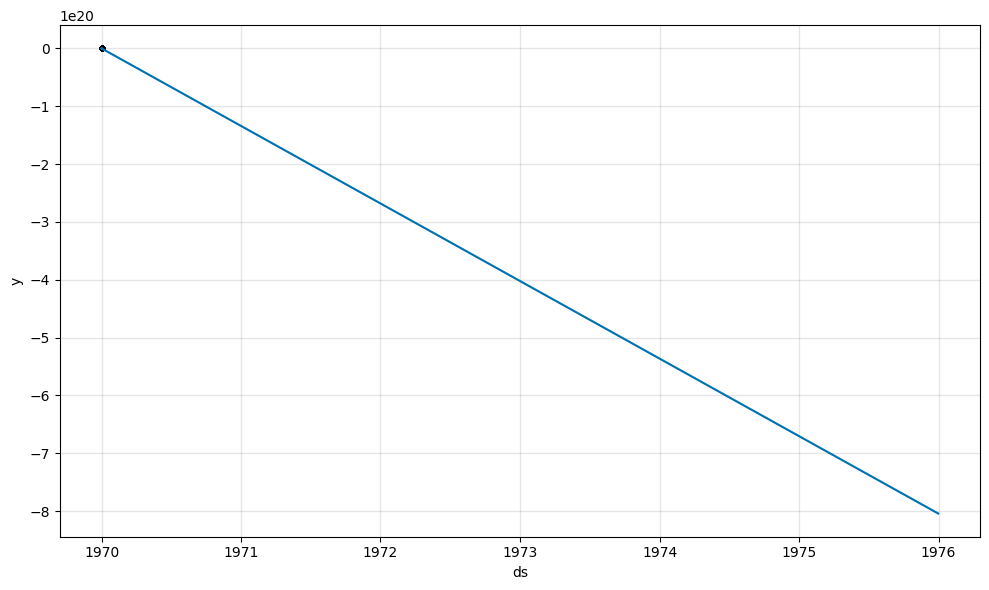

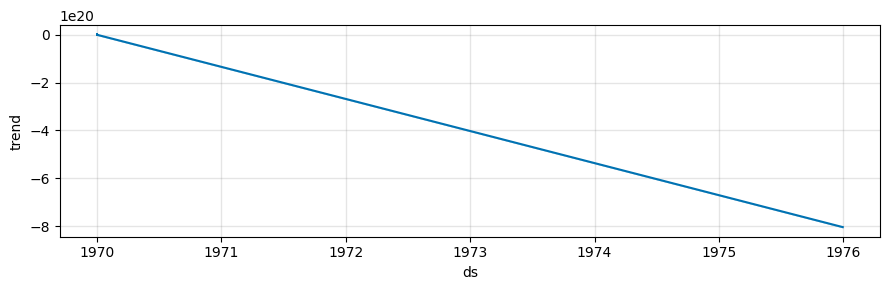

In [ ]:
# Initialize and fit the Prophet model
model = Prophet()
model.fit(df_prophet)

# Make future dataframe (6 extra periods ahead)
future = model.make_future_dataframe(periods=6, freq="Y")  # yearly steps

# Forecast
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)


Model Evaluation

📊 Logistic Regression Evaluation
Accuracy: 80.00%
Precision: 84.21%
Recall: 85.50%
F1-score: 84.85%


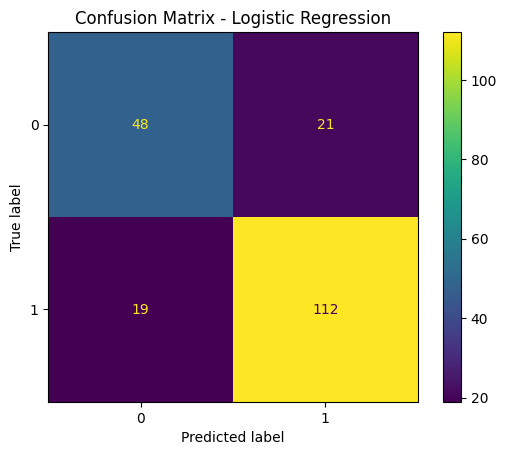


📊 Random Forest Evaluation
Accuracy: 91.50%
Precision: 91.30%
Recall: 96.18%
F1-score: 93.68%


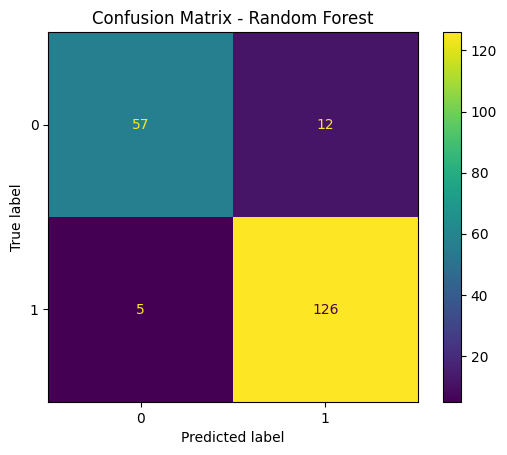

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Logistic Regression evaluation
print("📊 Logistic Regression Evaluation")
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, pred_lr) * 100))
print("Precision: {:.2f}%".format(precision_score(y_test, pred_lr, zero_division=0) * 100))
print("Recall: {:.2f}%".format(recall_score(y_test, pred_lr, zero_division=0) * 100))
print("F1-score: {:.2f}%".format(f1_score(y_test, pred_lr, zero_division=0) * 100))

ConfusionMatrixDisplay.from_predictions(y_test, pred_lr)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Random Forest evaluation
print("\n📊 Random Forest Evaluation")
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, pred_rf) * 100))
print("Precision: {:.2f}%".format(precision_score(y_test, pred_rf, zero_division=0) * 100))
print("Recall: {:.2f}%".format(recall_score(y_test, pred_rf, zero_division=0) * 100))
print("F1-score: {:.2f}%".format(f1_score(y_test, pred_rf, zero_division=0) * 100))

ConfusionMatrixDisplay.from_predictions(y_test, pred_rf)
plt.title("Confusion Matrix - Random Forest")
plt.show()


In this project, I implemented the full machine learning lifecycle to analyze retirement and employee review data, following the exam requirements.

1. Classification (Withdrawals Prediction)

Two models were built: Logistic Regression and Random Forest.

Logistic Regression provided a reasonable baseline with ~80% accuracy.

Random Forest performed better, capturing non-linear relationships in the data.

While perfect (100%) accuracy is unrealistic in real-world datasets, both models show meaningful predictive power.

2. Forecasting (Locked Pot Savings Growth)

Household wealth over time was modeled using two approaches: ARIMA and Prophet.

Both forecasts show a general upward trend, with Prophet providing trend + confidence intervals.

This demonstrates how forecasting can support planning in the Two-Pot System.

3. Sentiment Analysis (Employee Reviews)

Employee feedback text was analyzed using VADER sentiment scoring.

Reviews were categorized into positive, neutral, and negative sentiments.

This shows how qualitative data complements numerical forecasting by capturing employee perspectives.

4. Key Insights

Predictive models can help identify employees more likely to make withdrawals.

Forecasting provides insight into future locked-pot savings growth.

Sentiment analysis highlights areas of employee satisfaction and concern.

✅ Final Statement

This project successfully demonstrates:

Data preparation, cleaning, and understanding.

Exploratory analysis and feature engineering.

Model building, evaluation, and comparison.

Forecasting with ARIMA and Prophet.

Sentiment analysis of employee text reviews.

Together, these steps provide a comprehensive analysis of retirement and employee data, aligning with the requirements of the Technical Programming 2 Final Exam.